In [2]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from skimage.draw import line_aa
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import torchvision.transforms as T
import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [159]:
# Create the train data


# Create Gaussian blurs with varying widths and occluding bars
def create_Gaussian_blurs(nGauss=1000, imgSize=91):
    """
    Create a set of random occluding bars.
    Returns:
        images (torch.Tensor): Tensor containing the generated images.
    """
    # Create a grid of points
    # Initialize tensor containing Gaussian blur images
    images = torch.zeros(nGauss, 1, imgSize, imgSize)
    labels = torch.zeros(nGauss, 1)
    classes = ["Horiz.", "Vert."]
    for i in range(nGauss):
        # Create Gaussian blur
        G = np.random.randn(imgSize, imgSize) / 2

        # Add random bar randomly
        i1 = np.random.choice(np.arange(2, 28))
        i2 = np.random.choice(np.arange(2, 6))

        if np.random.randn() > 0:
            G[i1 : (i1 + i2*3),] = 1
            labels[i] = 0
        else:
            G[:, i1 : (i1 + i2*3)] = 1
            labels[i] = 1

        # Add to the tensor images
        images[i, :, :, :] = torch.tensor(G).view(1, imgSize, imgSize)
    return images, labels, classes


# Create Gaussian blur images
imgSize = 91
nGauss_train = 10000
nGauss_dev = 1000
train_images, train_labels, classes = create_Gaussian_blurs(nGauss_train, imgSize)
dev_images, dev_labels, classes = create_Gaussian_blurs(nGauss_dev, imgSize)

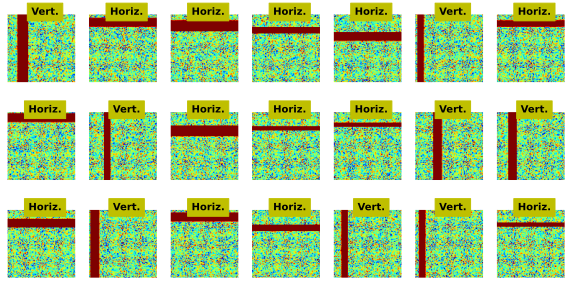

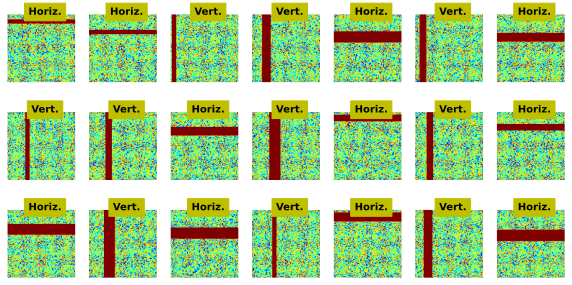

In [163]:
# visualize some train images
fig, axs = plt.subplots(3, 7, figsize=(10, 5))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss_train)
    label = train_labels[whichpic]
    im_class = classes[int(label[0])]
    G = np.squeeze(train_images[whichpic, :, :])
    ax.imshow(G.cpu(), vmin=-1, vmax=1, cmap="jet", label=im_class)
    ax.text(
        50, 0, im_class, ha="center", fontweight="bold", color="k", backgroundcolor="y"
    )
    ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

# visualize some dev images
fig, axs = plt.subplots(3, 7, figsize=(10, 5))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss_dev)
    label = dev_labels[whichpic]
    im_class = classes[int(label[0])]
    G = np.squeeze(dev_images[whichpic, :, :])
    ax.imshow(G.cpu(), vmin=-1, vmax=1, cmap="jet", label=im_class)
    ax.text(
        50, 0, im_class, ha="center", fontweight="bold", color="k", backgroundcolor="y"
    )
    ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [184]:
# Test data initialization
# Create the train data


# Create Gaussian blurs with varying widths and occluding bars
def create_test_images(nGauss=1000, imgSize=91):
    """
    Create a set of random occluding bars.
    Returns:
        images (torch.Tensor): Tensor containing the generated images.
    """
    # Create a grid of points
    # Initialize tensor containing Gaussian blur images
    images = torch.zeros(nGauss, 1, imgSize, imgSize)
    for i in range(nGauss):
        # Create Gaussian blur
        # Add random bar randomly
        image = torch.zeros((91, 91))
        r0 = np.random.choice(np.arange(0, 91))
        c0 = np.random.choice(np.arange(0, 91))
        r1 = np.random.choice(np.arange(0, 91))
        c1 = np.random.choice(np.arange(0, 91))
        rr, cc, val = line_aa(r0 , c0, r1, c1)
        image[rr, cc] = torch.tensor(val * 255).float()
        image = image.reshape((1, 91, 91))
        images[i] = image
    return images


# Create Gaussian blur images
imgSize = 91
nGauss_test = 100
test_images = create_test_images(nGauss_test, imgSize)
print(test_images.shape)

torch.Size([100, 1, 91, 91])


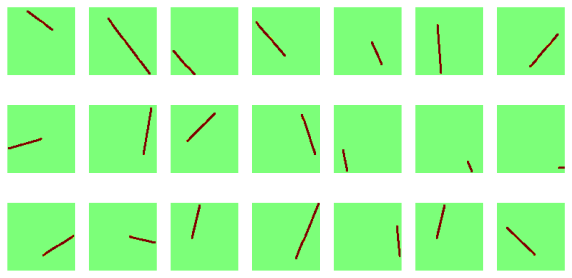

In [187]:
# visualize some test images
fig, axs = plt.subplots(3, 7, figsize=(10, 5))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss_test)
    G = np.squeeze(test_images[whichpic])
    ax.imshow(G.cpu(), vmin=-1, vmax=1, cmap="jet")
    # ax.text(
    #     50, 0, im_class, ha="center", fontweight="bold", color="k", backgroundcolor="y"
    # )
    ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()